<a href="https://colab.research.google.com/github/Vacayy/nlp-study/blob/main/DistilBERT_news_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 뉴스기사 분석 모델 학습하기


In [7]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt


#[MY CODE] 데이터셋 로드 및 전처리

- 1) AG_News 데이터셋 로드 2) 학습에 사용하기 위해 텍스트와 레이블 데이터를 전처리
- collate_fn 함수: 배치 데이터의 텍스트를 패딩 처리하여 고정된 크기의 입력으로 변환합니다
- DataLoader: 데이터셋을 배치 크기 단위로 나눠 학습과 테스트에서 사용할 수 있도록 준비합니다


In [8]:
# AG_News 데이터셋 로드
# - Huggingface의 fancyzhx/ag_news 데이터셋 로드(뉴스 기사를 4개의 클래스로 분류하는 데 사용)
ds = load_dataset('fancyzhx/ag_news')

# DistilBERT 토크나이저 초기화
# - Huggingface에서 제공하는 DistilBERT 토크나이저를 로드
# - 이 토크나이저는 DistilBERT 모델과 동일한 토큰화를 수행하며, 소문자 변환 및 WordPiece 방식을 사용
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

# Collate 함수 수정 (truncation 제거)
# - truncation 옵션을 제거하고, 입력 텍스트의 길이에 제한을 두지 않고 패딩 처리만 수행
def collate_fn(batch):
    texts, labels = [], []  # 텍스트와 레이블을 저장할 리스트 초기화
    for row in batch:
        # 데이터셋에서 각 행(row)의 'label' 값을 레이블 리스트에 추가
        labels.append(row['label'])
        # 데이터셋에서 각 행(row)의 'text' 값을 텍스트 리스트에 추가
        texts.append(row['text'])

    # 텍스트 데이터를 DistilBERT 토크나이저를 사용해 토큰화하고, 패딩 처리된 input_ids를 PyTorch LongTensor로 변환
    texts = torch.LongTensor(tokenizer(texts, padding=True).input_ids)
    # 레이블 리스트를 PyTorch LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 텍스트와 레이블 텐서 반환
    return texts, labels

# DataLoader 설정
# 학습 데이터셋을 DataLoader로 변환
# - 배치 크기(batch_size): 64
# - 데이터 셔플(shuffle): True (데이터 순서를 랜덤화)
# - Collate 함수: 위에서 정의한 collate_fn
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트 데이터셋을 DataLoader로 변환
# - 배치 크기(batch_size): 64
# - 데이터 셔플(shuffle): False (테스트 데이터는 순서 유지)
# - Collate 함수: 위에서 정의한 collate_fn
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

# 이후 TextClassifier를 정의하고 model을 다시 초기화하므로, 초기 DistilBERT 모델(model)은 실제로 학습이나 평가에 사용되지 않음
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
# model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


#[MY CODE] DistilBERT 모델 설정
- DistilBERT를 기반으로 한 뉴스 기사 분류 모델을 정의합니다.
- DistilBERT는 텍스트 임베딩을 생성하며, 마지막 [CLS] 토큰의 출력을 사용하여 분류 작업을 수행합니다.

In [9]:
# TextClassifier 정의
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # DistilBERT 모델 로드
        # huggingface/pytorch-transformers에서 DistilBERT 사전 학습 모델을 로드합니다.
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
        # 출력 레이어 정의
        # DistilBERT의 마지막 출력 크기(768)를 4개의 클래스에 매핑하는 선형 레이어를 정의합니다.
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # DistilBERT 모델을 통해 입력 텍스트의 임베딩을 생성
        x = self.encoder(x)['last_hidden_state']
        # [CLS] 토큰의 출력(x[:, 0])을 사용하여 최종 분류 결과 생성
        x = self.classifier(x[:, 0])
        return x

# TextClassifier 인스턴스 생성
model = TextClassifier()
model = model.to('cuda')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


#[MY CODE] DistilBERT 모델 파라미터 고정
- 사전 학습된 DistilBERT의 가중치를 고정하여 학습 중 업데이트되지 않도록 설정합니다.
- 이는 파라미터 고정을 통해 분류 레이어만 학습되도록 하기 위함입니다.

In [10]:
# DistilBERT의 파라미터 고정
for param in model.encoder.parameters():
    param.requires_grad = False

#[MY CODE] 손실함수 및 Acccuracy 함수 정의
- 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제이므로 CrossEntropyLoss 사용

In [11]:
# 손실 함수 및 옵티마이저 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# 정확도 함수 정의
def accuracy(model, dataloader):
    cnt = 0  # 전체 데이터 샘플 수를 저장할 변수
    acc = 0  # 정확히 예측된 샘플 수를 저장할 변수

    for data in dataloader:
        inputs, labels = data # DataLoader에서 배치 가져오기
        inputs, labels = inputs.to('cuda'), labels.to('cuda' ) # 입력 데이터, 레이블을 GPU로 이동

        preds = model(inputs) # 모델을 사용하여 예측값 계산
        preds = torch.argmax(preds, dim=-1) # 다중 클래스 분류에서는 가장 높은 확률의 클래스 선택 (argmax)

        # 정확히 예측된 샘플 수를 누적
        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    # 전체 데이터 중 정확히 예측된 비율 반환
    return acc / cnt

# [MY CODE] 학습 및 테스트 루프
1. 학습 루프:
- 모델을 train 모드로 설정하고, 데이터 배치를 반복하면서 손실을 계산합니다.
- 역전파(loss.backward())를 통해 그래디언트를 계산하고, 옵티마이저를 사용해 가중치를 업데이트합니다.
- 매 epoch마다 평균 손실 값을 출력합니다.
<br/><br/>

2. 테스트 루프:
- 모델을 eval 모드로 설정하여 평가를 수행합니다.
- 배치 단위로 테스트 데이터를 처리하며, 예측값과 실제값을 비교해 정확도를 계산합니다.
- 테스트 데이터에 대한 정확도를 출력합니다.

In [12]:
n_epochs = 10  # 학습 epoch 수
train_losses = []  # 각 epoch의 학습 손실을 저장하는 리스트
train_accuracies = []  # 각 epoch의 학습 정확도를 저장하는 리스트
test_accuracies = []  # 각 epoch의 테스트 정확도를 저장하는 리스트

# 학습 루프
for epoch in range(n_epochs):
    model.train()  # 모델을 학습 모드로 전환
    total_loss = 0  # 한 epoch 동안의 총 손실

    for data in train_loader:
        model.zero_grad()  # 모델의 기울기 초기화
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')  # 데이터와 레이블을 GPU로 이동

        preds = model(inputs) # 모델을 통해 예측값 계산
        loss = loss_fn(preds, labels) # 손실 함수 계산 (예측값과 실제 레이블 비교)
        loss.backward() # 역전파를 통해 기울기 계산
        optimizer.step() # 옵티마이저를 통해 파라미터 업데이트

        # 현재 배치의 손실을 총 손실에 누적
        total_loss += loss.item()

    # 학습 정확도 저장
    train_accuracy = accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)
    # train_losses.append(total_loss)

    # 테스트 데이터의 정확도 계산
    with torch.no_grad():
        model.eval()  # 모델을 평가 모드로 전환
        test_accuracy = accuracy(model, test_loader)  # 테스트 데이터 정확도 계산
        test_accuracies.append(test_accuracy)  # 정확도 저장

    # 한 epoch의 결과 출력
    print(f"Epoch {epoch + 1}/{n_epochs} | Train Loss: {total_loss:.4f} | "
          f"Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

    # 학습 손실 저장
    # 데이터셋의 크기와 배치 크기(batch size)에 따라 한 epoch에서의 배치 개수(len(train_loader))가 달라질 수 있음
    train_losses.append(total_loss / len(train_loader))


Epoch 1/10 | Train Loss: 885.4211 | Train Accuracy: 0.8735 | Test Accuracy: 0.8784
Epoch 2/10 | Train Loss: 700.4332 | Train Accuracy: 0.8781 | Test Accuracy: 0.8801
Epoch 3/10 | Train Loss: 670.4549 | Train Accuracy: 0.8812 | Test Accuracy: 0.8830
Epoch 4/10 | Train Loss: 656.2560 | Train Accuracy: 0.8819 | Test Accuracy: 0.8833
Epoch 5/10 | Train Loss: 653.0294 | Train Accuracy: 0.8818 | Test Accuracy: 0.8883
Epoch 6/10 | Train Loss: 645.6945 | Train Accuracy: 0.8854 | Test Accuracy: 0.8868
Epoch 7/10 | Train Loss: 640.2064 | Train Accuracy: 0.8841 | Test Accuracy: 0.8867
Epoch 8/10 | Train Loss: 639.7421 | Train Accuracy: 0.8817 | Test Accuracy: 0.8887
Epoch 9/10 | Train Loss: 637.0445 | Train Accuracy: 0.8770 | Test Accuracy: 0.8811
Epoch 10/10 | Train Loss: 634.0827 | Train Accuracy: 0.8856 | Test Accuracy: 0.8912


# [MY CODE] 결과 출력

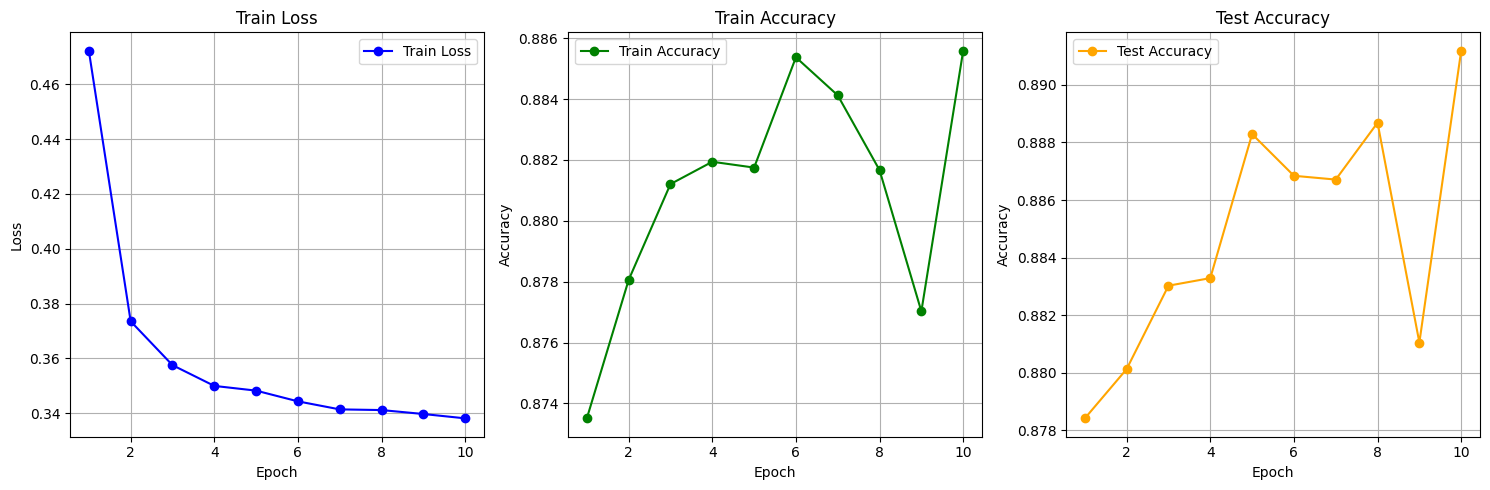

In [13]:
plt.figure(figsize=(15, 5))

# Train Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, n_epochs + 1), train_losses, marker='o', label='Train Loss', color='blue')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True) # 격자
plt.legend() #

# Train Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, marker='o', label='Train Accuracy', color='green')
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Test Accuracy
plt.subplot(1, 3, 3)
plt.plot(range(1, n_epochs + 1), test_accuracies, marker='o', label='Test Accuracy', color='orange')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()